In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-weather-surface-brazil-southeast-region/sudeste.csv


In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams["patch.force_edgecolor"] = True


In [3]:
df_original = pd.read_csv("/kaggle/input/hourly-weather-surface-brazil-southeast-region/sudeste.csv", )
# df = pd.concat(df_original)

# Sample Data
Due to large data lets work with sampel data****

In [222]:
sample_df = df_original.sample(100000,random_state=101)

Dataset is too big so lets import in a chunk and work with the smallest one at first

## Info On Some Columns


1. Instant Air Temperature (celsius degrees) = temp
2. Maximum Air Temperature (celsius degrees) = tmin
3. Minimum Air Temperature (celsius degrees) = tmax
4. Relative Humidity of Air (%) =hmdy
5. Maximum Relative Air Humidity (%) =hmax
6. Minimum Relative Air Humidity (%) = hmin
7. Instant Dew Point (celsius degrees) = dewp
8. Maximum Dew Point (celsius degrees)=dmax
9. Minimum Dew Point Temperature (celsius degrees) = dmin
10. Instant Air Atmospheric Pressure (millibars) =stp
11. Maximum Air Atmospheric Pressure (millibars) = smax
12. Minimum Air Atmospheric Pressure (millibars)= smin
13. Instant Wind Speed (metres per second) = wdsp
14. Wind Direction (radius degrees) = wdct
15. Wind Gust Intensity (metres per second) = gust
16. Solar radiation  =  gbrd
17. Precipitation (milimetres) = prcp
18. Elevation = elvt
19. Observation Datetime = mdct
20. Observation Date = date
21. Station number (INMET number) for the location = inme
22. The year (2000-2016) : yr
23. The month (0-12) : mo
24. The day (0-31): da
25. The hour : hr

*Not all the columns are mentioned in this list*

In [223]:
# print(sample_df.info())

# Tidying Data

## Drop Elvt,Lat and Long

 Lat, long and elevation gives location to  city. So remove elevation, longitude and lattitude in the first version of analysis. 

In [224]:
# df.drop(['lat','lon', 'elvt'],inplace=True, axis=1)
sample_df.drop(['lat','lon', 'elvt'], axis=1,inplace=True)

In [225]:
print(sample_df.iloc[:,:10].head(1))
print("=="*20)
print(sample_df.iloc[:,10:20].head(1))
print("=="*20)

print(sample_df.iloc[:,20:].head(1))

        wsid        wsnm  inme        city prov                 mdct  \
444352   307  SÃO MATEUS  A616  São Mateus   ES  2009-09-10 16:00:00   

              date    yr  mo  da  
444352  2009-09-10  2009   9  10  
        hr  prcp     stp    smax    smin      gbrd  temp  dewp  tmax  dmax
444352  16   NaN  1017.7  1018.4  1017.7  2526.037  27.5  18.6  28.4  19.6
        tmin  dmin  hmdy  hmax  hmin  wdsp  wdct  gust
444352  26.9  18.0  58.0  63.0  55.0   4.6  92.0   7.7


In [226]:
#Drop the weather station name since its being represented as wsid


sample_df.drop('wsnm', axis=1,inplace=True)

## Drop Multiple Time related columns

There are five columns on time of observatoin. They are mdct, date,yr, month and hour, which are same but separated into several sctions. Among them Date and Hour columns are useful and represent all in some form, so others can be dropped. The conversion of date column to datetime gave format error. So, first lets combine the yr,mo,da and hr columns to make one and then drop them

In [227]:
sample_df['date']=pd.to_datetime(sample_df[['yr', 'mo', 'da','hr']].rename(columns={'yr': 'year','mo': 'month','da': 'day','hr':'hour'}))

In [228]:
sample_df.drop(['mdct','yr','da','hr','mo'], axis= 1, inplace=True)

Reset Index as Date column and the check for duplicates data on same date in same city and remove them

In [229]:
sample_df.set_index('date',inplace=True,drop=True)

Since there is no null values,under the assumption that all the data from various weather stations are valid and true, lets not filter the time of operation of weather stations and drop the wsids and inme, only city adn prov are enough.

In [230]:
# df.drop(['wsid','inme'], inplace=True, axis=1)
sample_df.drop(['wsid','inme'],inplace=True, axis=1)

# Exploration and Manipulation

In [231]:
sample_df.isnull().sum()

city        0
prov        0
prcp    85512
stp         0
smax        0
smin        0
gbrd    41993
temp        0
dewp        2
tmax        1
dmax        4
tmin        0
dmin        9
hmdy        0
hmax        0
hmin        0
wdsp     9398
wdct        0
gust     3262
dtype: int64

## Missing Data Visualization Using Heatmap

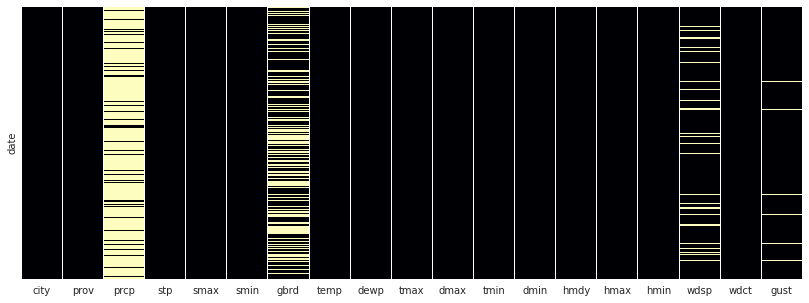

In [232]:
plt.figure(figsize=(14,5))
sns.heatmap(sample_df.isnull(),cmap='magma', cbar=False, yticklabels=False)

The figure shows that the prcp and gbrd have a lot of missing data. Lets check in actual percentage the amount of missing data. But heatmap cannot capture small percentage like tmin and tmax due to size difference.

## Missing data percentage calculation

Reutrn the columns with null values greater than 40% of total length of df.

 $((df[col].isna().sum()*100) / df.shape[0])$ gives the null percentage of the relevant column.
 
  $df[col].isna().sum() > round(0.4 * df.shape[0])$ checks if null percentage is more than 40% of toal length.Finally gives col and null percentage as key and value pair if the null amount is more thank 40 percentage

In [233]:


columns_40_percent_plus_null = {col:((sample_df[col].isna().sum()*100)/ sample_df.shape[0]) for col in sample_df.columns if sample_df[col].isna().sum() > 
                                round(0.4 * sample_df.shape[0]) }

In [234]:
columns_40_percent_plus_null

{'prcp': 85.512, 'gbrd': 41.993}

lets Drop both gbrd and prcp columns. And also nan rows from  temp,tmax,tmin columns since its really small.

In [235]:
sample_df.drop(['prcp','gbrd'], inplace=True,axis=1)

In [236]:
sample_df.dropna(subset=['tmax','temp','tmin'],inplace=True)

Just for the sake of argument fill the missing values in dewp, dmax with average values

In [237]:
sample_df['dmax'].fillna(sample_df['dmax'].mean(),inplace=True)
sample_df['dewp'].fillna(sample_df['dewp'].mean(),inplace=True)

### Windspeed and Gust Column missing vals

This [article](https://sciencing.com/winds-formed-5145233.html) suggests that wind-speed is affected by temperature and air pressure. So,lets find mean of windspeed between range of temp fill nans accordingly.

This [article](http://www.differencebetween.net/science/nature/difference-between-gust-and-wind/#:~:text=A%20gust%20is%20a%20sudden,comes%20in%202%2Dminute%20intervals.&text=A%20gust%20and%20wind%20both,earth's%20atmosphere%20around%20the%20earth.) suggest that gust is sudden change in windspeed due to terrain. So, using instant temperature to weighted mean to replace nans seems feaible for gust

In [238]:
print(sample_df['temp'].value_counts(bins=5).sort_index())


(-3.447, 5.82]     6623
(5.82, 15.04]      8143
(15.04, 24.26]    56291
(24.26, 33.48]    27821
(33.48, 42.7]      1121
Name: temp, dtype: int64


Instead of looping throuh ranges 10 intervals , lets just use 5 intervals like above

In [239]:
# Create five ranges of mean according to above interval for windspeed

first_range_mean_wdsp= sample_df[((sample_df['temp']>=-3.447) & (sample_df['temp']<5.82)) ]['wdsp'].mean()
second_range_mean_wdsp= sample_df[((sample_df['temp']>=5.82) & (sample_df['temp']<15.04))  ]['wdsp'].mean()
third_range_mean_wdsp= sample_df[((sample_df['temp']>=15.04) & (sample_df['temp']<24.26))  ]['wdsp'].mean()
fourth_range_mean_wdsp= sample_df[((sample_df['temp']>=24.26) & (sample_df['temp']<33.48))  ]['wdsp'].mean()
fifth_range_mean_wdsp= sample_df[((sample_df['temp']>=33.48) & (sample_df['temp']<42.7)) ]['wdsp'].mean()

In [240]:

# Create five ranges of mean according to above interval for airpressure

first_range_mean_gust= sample_df[((sample_df['temp']>=-3.447) & (sample_df['temp']<5.82)) ]['gust'].mean()
second_range_mean_gust= sample_df[((sample_df['temp']>=5.82) & (sample_df['temp']<15.04))  ]['gust'].mean()
third_range_mean_gust= sample_df[((sample_df['temp']>=15.04) & (sample_df['temp']<24.26))  ]['gust'].mean()
fourth_range_mean_gust= sample_df[((sample_df['temp']>=24.26) & (sample_df['temp']<33.48))  ]['gust'].mean()
fifth_range_mean_gust= sample_df[((sample_df['temp']>=33.48) & (sample_df['temp']<42.7)) ]['gust'].mean()

In [241]:
print(first_range_mean_wdsp, second_range_mean_wdsp,third_range_mean_wdsp,fourth_range_mean_wdsp,fifth_range_mean_wdsp)
print(first_range_mean_gust, second_range_mean_gust,third_range_mean_gust,fourth_range_mean_gust,fifth_range_mean_gust)

0.04393777642214428 1.8885478342162743 1.998070520277601 2.474517157322322 2.4622504537205057
0.10679405520169853 3.809891143663473 4.432743052349683 5.775794808225169 6.443202146690513


Create a function to fill missing values

In [242]:
# this funciton will take two cols, temp and wdsp in this order
#math is imported to check nan, np.nan wont work
def fill_missing_wdsp(col):
    import math
#Initialize relevant cols
    temp = col[0]
    wdsp = col[1]
    
    # If the value is nan
    #Assign by ranges declared above
    if math.isnan(wdsp):
        if(temp<5.82):
            return first_range_mean_wdsp
        elif(temp>=5.82) and (temp<15.04):
            return second_range_mean_wdsp
        elif(temp>=15.04) and (temp<24.26):
            return third_range_mean_wdsp
        elif(temp>=24.26) and (temp<33.48):
            return fourth_range_mean_wdsp
        elif(temp>=33.48):
            return fifth_range_mean_wdsp
        #if not nan return as it is
    else:
        return wdsp
    
    

In [243]:
# this funciton will take two cols, temp and gust in this order
#math is imported to check nan, np.nan wont work
def fill_missing_gust(col):
    import math
#Initialize relevant cols
    temp = col[0]
    gust = col[1]
    
    # If the value is nan
    #Assign by ranges declared above
    if math.isnan(gust):
        if(temp<5.82):
            return first_range_mean_gust
        elif(temp>=5.82) and (temp<15.04):
            return second_range_mean_gust
        elif(temp>=15.04) and (temp<24.26):
            return third_range_mean_gust
        elif(temp>=24.26) and (temp<33.48):
            return fourth_range_mean_gust
        elif(temp>=33.48):
            return fifth_range_mean_gust
        #if not nan return as it is
    else:
        return gust
    

In [244]:
sample_df['wdsp'] = sample_df[['temp','wdsp']].apply(fill_missing_wdsp,axis=1)
sample_df['gust'] = sample_df[['temp','gust']].apply(fill_missing_gust,axis=1)



# Data Analysis

## Questions To Explore
1. Data Share by Province
2. Avg air pressure by Province per year
3. Avg air pressure by City per year
4. Air pressure per city comparision
5. Where can u cook faster? Air pressure
6. Compare temperatures of different cities
7.  Days with most fluctuations like temp,wind
8. Temperature Change weekly,monthly or yearly
9. Seasonal Forecasting
10. Different Variables and their relation with each-other.like wind with humidity.
11. Gusty city of all time

### Data share By Province

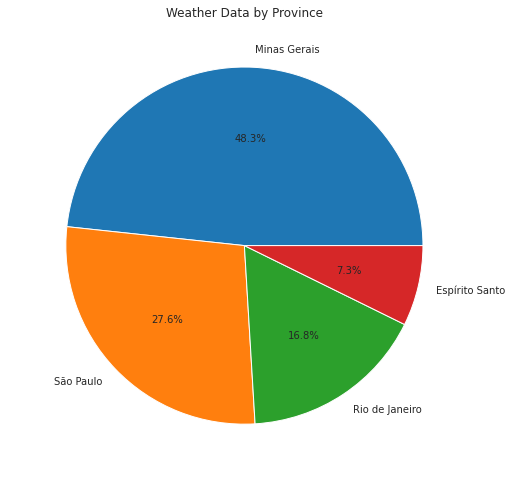

In [245]:
sample_df['prov'].value_counts(normalize=True).plot.pie(figsize=(8,10),autopct = '%.1f%%',labels=['Minas Gerais','São Paulo','Rio de Janeiro','Espírito Santo'])
plt.xlabel(" ")
plt.ylabel(" ")
# plt.legend(['Minas Gerais','São Paulo','Rio de Janeiro','Espírito Santo'], loc=0)
plt.title('Weather Data by Province');

It seems abot 50% of the data is related to *Minas Gerlas* province of Brazil

In [246]:
sample_df.columns

Index(['city', 'prov', 'stp', 'smax', 'smin', 'temp', 'dewp', 'tmax', 'dmax',
       'tmin', 'dmin', 'hmdy', 'hmax', 'hmin', 'wdsp', 'wdct', 'gust'],
      dtype='object')

City and Province are categorical, nominal values. All other columns are quantitative,continuous and ratio scale. 

## Air Pressure Table

In [247]:
air_df=sample_df[['city','prov','stp','smax','smin']]

### Average Minimum and Maximum Air pressure per prov per yr

In [248]:
air_pressure_min_max = air_df.pivot_table(columns=air_df.index.year,index='prov',values=['smax','smin'],aggfunc='mean').stack()


**Where can you cook faster?**

In [293]:
air_pressure_min_max[air_pressure_min_max.smax == air_pressure_min_max.smax.max()]

,,smax,smin
prov,date,,
ES,2006,1008.042029,1007.494203


In province 'Espírito Santo' we can pressure cook faster. *Air pressure can change the time of **pressure** cooking*

In [249]:
provinces = sample_df.prov.unique().tolist()
provinces_dict= {'MG':'Minas Gerais','SP':'São Paulo','RJ':'Rio de Janeiro','ES':'Espírito Santo'}


<Figure size 720x432 with 0 Axes>

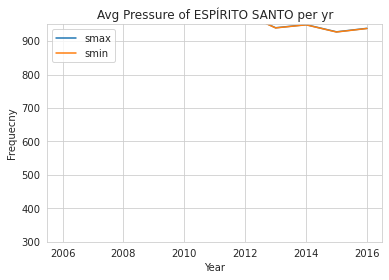

<Figure size 720x432 with 0 Axes>

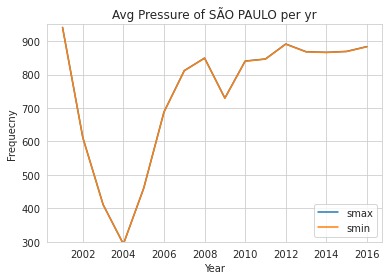

<Figure size 720x432 with 0 Axes>

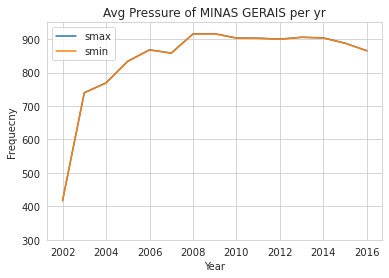

<Figure size 720x432 with 0 Axes>

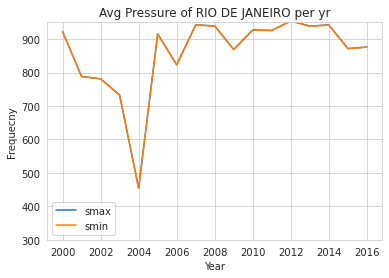

In [250]:
for prov in provinces:
    plt.figure(figsize=(10,6))
    air_pressure_min_max.loc[prov].plot();
    plt.title("Avg Pressure of {} per yr".format(provinces_dict[prov].upper()))
    plt.xlabel('Year')
    plt.ylabel('Frequecny')
    plt.legend(loc=0)
    plt.ylim((300,950))
    plt.show();


# air_pressure_min_max.plot( label=city);


The graph shows quite similar characters between *Rio de Janerio* and *Sao Paulo* especially theres a drastic changes from 2003-2005, if we compare the charts starting from 2002. While in *Espirito Santo* there has never been pressure below 900.

### Find out the mean air pressure (instant) values yearly for the chosen city and plot it

Create the function with the input value is the city name then it shows its data table for average air pressure (instant) yearly and line chart

In [251]:
def pressure_city_yearly(val):
    b=air_df[air_df['city']==val]
    yearly=b.groupby(b.index.year)['stp'].agg('mean')
#     print(val)
#     print(yearly)
    plt.figure(figsize=(12,5))
    yearly.plot(kind='line',color='blue')
    plt.title(val.upper())
    plt.ylim((850,960))
    plt.ylabel("Frequency")


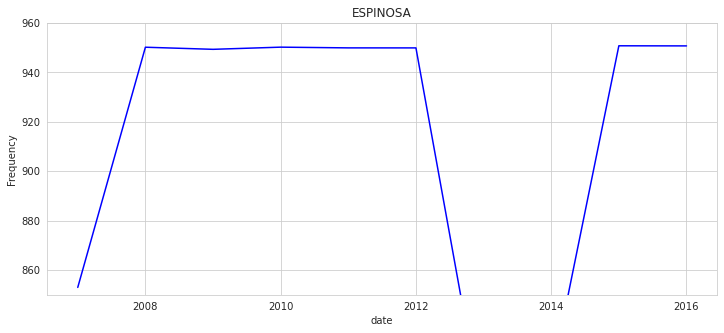

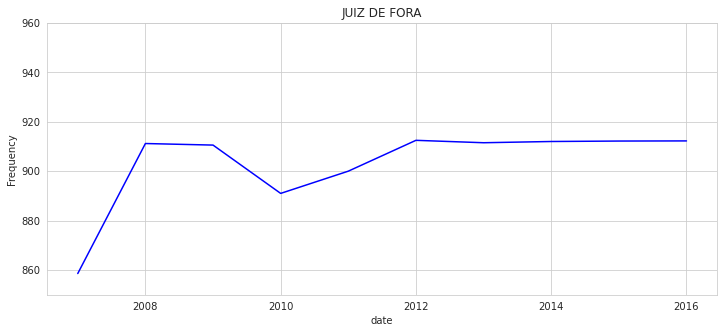

In [252]:

pressure_city_yearly('Espinosa');
# pressure_city_yearly('Afonso Cláudio');
pressure_city_yearly('Juiz de Fora');



These two cities have mostly air pressure 900+. While pressure dropped from around 2009 - 2010 in **Juiz de Fora** to about 890. Average air pressure of 2012-2013 has changed  from 940 to below 860 in a linear fashion for **Espinosa**.

Lets dive even depper in next cell using year,city and month.


### Sketching the chart for specific air pressure values with year, month and city

Create a function which shows the data from given year, month and city name then plots it




In [253]:
def monthly_plot(m,y,c,ylim):
    # Get pressure record by given month and year
    air_m_y=air_df[(air_df.index.month == m) & (air_df.index.year == y)]
    
    # Extract given city from  above record
    air_m_y_c=air_m_y[air_m_y['city']==c]

    fig=plt.figure(figsize=(10,6))
    air_m_y_c['stp'].plot(kind='line',color='red')
    # Ylim because comparision should be within same range,
    plt.ylim(ylim)
    plt.title(' Avg Air pressure of city {} in {}-{}'.format(c.upper(),m,y));

Lets check some cities from same province first, during same times.

In [254]:
# For prov "MG"
minas_cities = air_df[air_df.prov=="MG"].city
# lets just use 5 cities at random
minas_cities[:5]

date
2011-12-20 12:00:00              Viçosa
2011-01-13 10:00:00        Juiz de Fora
2016-03-30 23:00:00             Mantena
2011-07-06 13:00:00    São João del Rei
2007-07-06 05:00:00             Formiga
Name: city, dtype: object

We are trying for yr 2008, if u remember plot by prov by year the pressure range in **MG** during 2008 is about 900-100

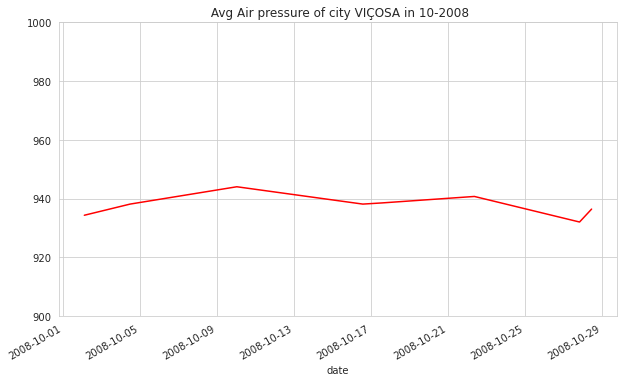

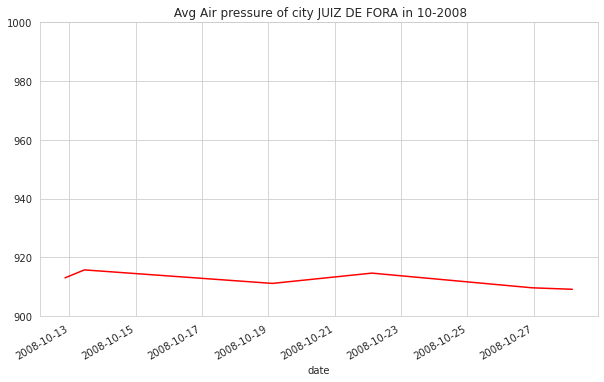

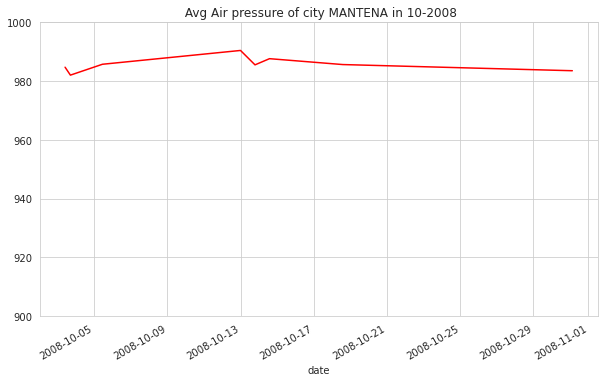

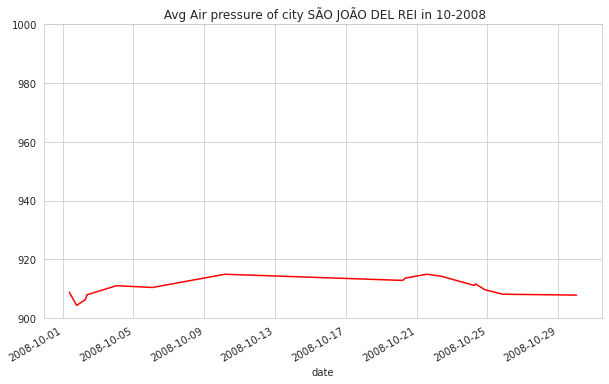

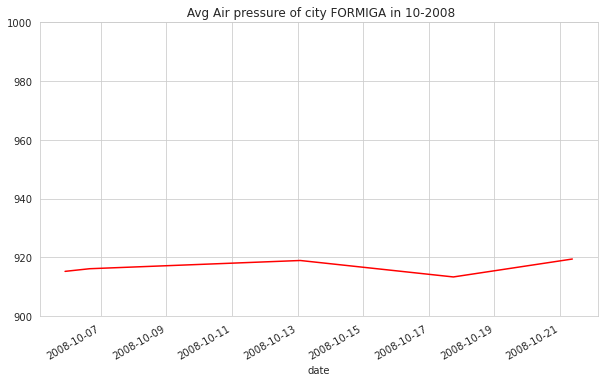

In [255]:
monthly_plot(10,2008,'Viçosa',(900,1000))
monthly_plot(10,2008,'Juiz de Fora',(900,1000))
monthly_plot(10,2008,'Mantena',(900,1000))
monthly_plot(10,2008,'São João del Rei',(900,1000))
monthly_plot(10,2008,'Formiga',(900,1000))


City *Maneta* is the only one with air pressure in the upper range around the year, while *Vicosa's* in the middle range and other 3 are in lower range.

## Temperature Table

In [256]:
temperature_df=sample_df[['city','temp','tmax','tmin']]

In [258]:
def get_temp_by_choice(yr,mo,c):
    # Get temperature record by given month and year
    temp_m_y_c=temperature_df[(temperature_df.index.year==yr) & (temperature_df.index.month==mo) & (temperature_df.city == c)]
    
    
    # Extract given city from  above record
    temp_max = temp_m_y_c.max()
    temp_min = temp_m_y_c.min()
    print(temp_max)
    print(temp_min)
    print("=="*20)
#     return temp_max, temp_min

Now we can extract temp records of our choice lets, try few.

In [259]:
get_temp_by_choice(2008,10,"Viçosa")
get_temp_by_choice(2008,10,"Valença")
get_temp_by_choice(2008,10,"Montalvânia")
get_temp_by_choice(2008,10,"Itaobim")



city    Viçosa
temp      31.5
tmax      33.2
tmin      31.5
dtype: object
city    Viçosa
temp      14.8
tmax      14.9
tmin      14.8
dtype: object
city    Valença
temp       26.6
tmax       27.1
tmin       26.6
dtype: object
city    Valença
temp       15.8
tmax       15.8
tmin       15.7
dtype: object
city    Montalvânia
temp           35.1
tmax             36
tmin           35.1
dtype: object
city    Montalvânia
temp           20.5
tmax           23.4
tmin           19.8
dtype: object
city    Itaobim
temp       33.4
tmax         35
tmin       33.4
dtype: object
city    Itaobim
temp       22.2
tmax       23.6
tmin       21.8
dtype: object


In October of 2008, *Viçosa* was the coldest and *Montalvânia* was the hottest one.

### Plot By Custom Choice

The following function will plot Average  line plot of city of choice on timeline of choice from some timeline of choice.

In [260]:
timeline={"Weekly":"W","Monthly":"M","Yearly":"Y"}

# provide timeline among weekly, monthly or yearly. The default value is Yearly.
# Remember y_lim has not been set so, comparision might not be good idea
def temp_analysis(city, time_line="Yearly"):
    
    c=temperature_df[temperature_df['city']==city]
    #print(c)
    # Resample it on average
    d=c.resample(timeline[time_line.title()]).mean()
    #Find extremes
    max_tmax = d['tmax'].max()
    min_tmin = d['tmin'].min()
    max_temp = d['temp'].max()
    
    plt.figure(figsize=(15,10))
    # plot temperatures
    d['tmax'].plot(color='green',label="{} Tmax".format(city))
    d['tmin'].plot(color='red',label="{} Tmin".format(city))
    d['temp'].plot(color='blue',label="{} Temp".format(city))
    
    # Plot min or max hlines
    plt.axhline(max_tmax,color="green",linestyle='--', label="Maximum value of Tmax")
    plt.axhline(min_tmin,color="red",linestyle='--',label="Minimum value of Tmin")
    plt.axhline(max_temp,color="blue",linestyle='--',label="Maximum value of Tmemp")

    #Set spines invisible
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    
    #Set grid invisible
    plt.grid(False)
    
    plt.xlabel("{} {}".format(city.title(), time_line))
    plt.ylabel("Average Temps")
    plt.title("Average {} temperatures of {}".format(time_line, city.upper()))
    plt.legend(loc=0)

    
    
    plt.show()



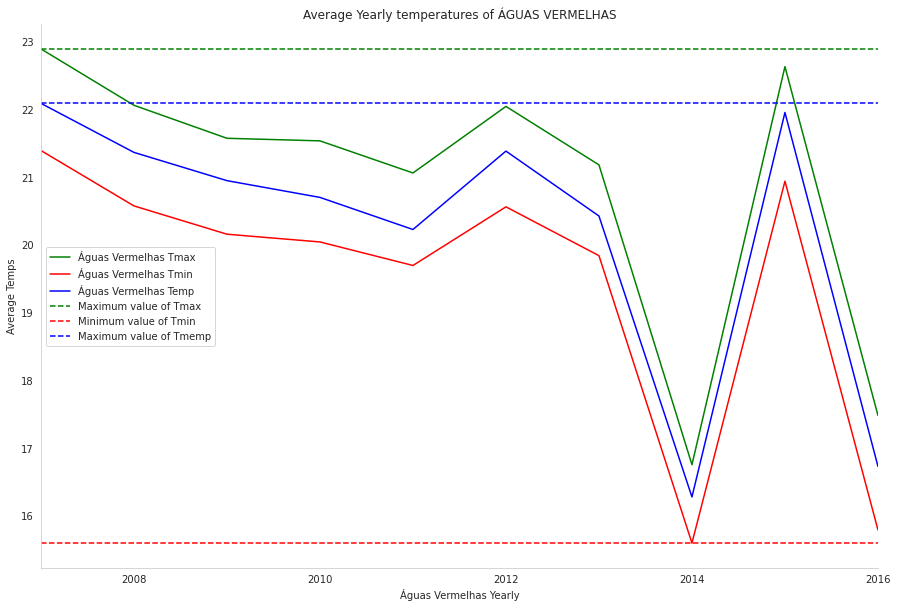

In [261]:
#temp_analysis('Vitória',"Yearly")
temp_analysis('Águas Vermelhas')



Looks like 2013-2016 have been periods of ups and downs. Average temperature  fell from about 20.5 to  16.5 from 2013 t0 2014 and again rose to about 22 degrees on average and theres slopy journey again to 2016.

Lets normalize the dataset first to neutralize different units

In [262]:
from sklearn.preprocessing import StandardScaler

In [263]:
scaler = StandardScaler()
# Take a copy of sample_df
sample_df_norm = sample_df.copy()
#Normalize numeric scales
sample_df_norm.iloc[:,2:] = scaler.fit_transform(sample_df.iloc[:,2:].copy())

### Seasonal Fluctuations

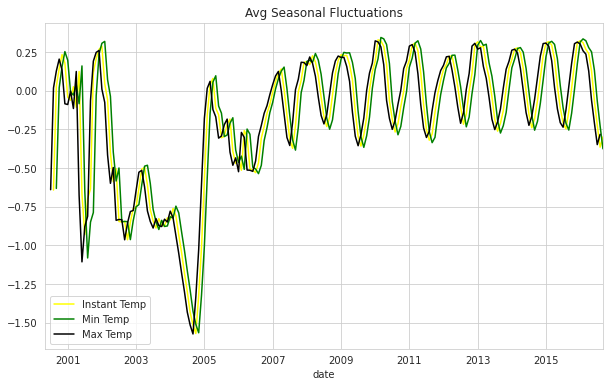

In [313]:
# Assuming 4 mnths seasons
# Lets obsorve seasoal fluctuation
plt.figure(figsize=(10,6))
sample_df_norm.temp.resample('M').mean().rolling(4).mean().plot(label="Instant Temp",color='yellow')
sample_df_norm.tmin.resample('M').mean().rolling(4).mean().shift(1).plot(label="Min Temp", color='green')
sample_df_norm.tmax.resample('M').mean().rolling(4).mean().shift(-1).plot(label="Max Temp",color='black')
plt.title("Avg Seasonal Fluctuations")
plt.legend(loc=0);

On average fluctation was noticeable during yr 2001 and 2006. Slightly however, there is constant sloppy decrease in temp from 2004 to 2006.

## Gusty City of All Time

In [295]:
gust_yr_city = sample_df_norm.pivot_table(columns=sample_df_norm.index.year,index='city',values=['gust'],aggfunc='mean').stack()


In [311]:
gusty_city= gust_yr_city.loc[gust_yr_city['gust']==gust_yr_city.gust.max()].index[0]
gusty_city

('Petrópolis', 2007)

Among the cities, the gusty city is "Petrópolis" in year 2007.

# Variables and Correlations

## Heatmap of Corr

In [269]:
# Create a correlation matrix
corr = sample_df_norm.corr()

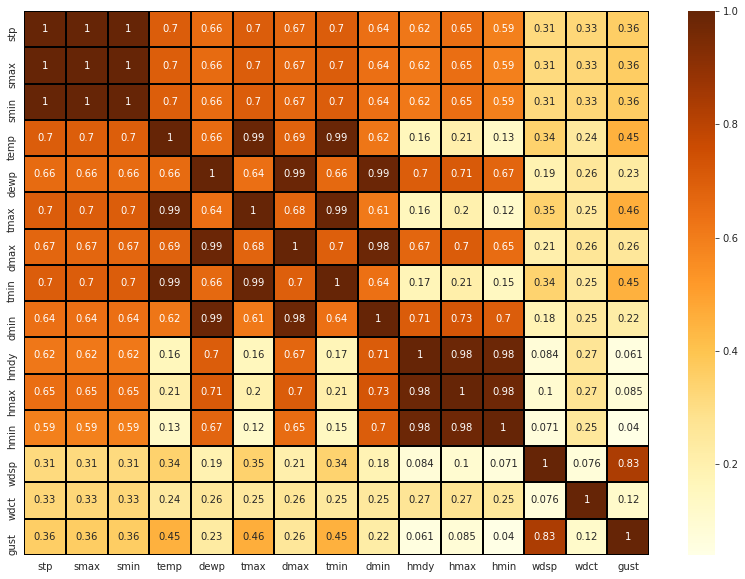

In [279]:
plt.figure(figsize=(14,10));
sns.heatmap(corr, annot=True, lw=1,linecolor="#000", cmap='YlOrBr');

Above heatmap shows obvious high correlation between similar variables like (temp,tmax and tmin), (stp,smax and smin) and so on. However, it shows higher correaltion btween variables of dew points with humidity. It can implied that more due forms for humidity. The jointplot "Dew and Humidity" also proves the point. Moreover, the aspect of temperature(temp,tmax and tmin) and airpressure (stp,smax and smin) also have high correlation between them.  

It appears aspects wind-speeds have very low correlatoin with humidity. Windspeed and Humidity plot below will make this more clear.  

### Dew and Humidity

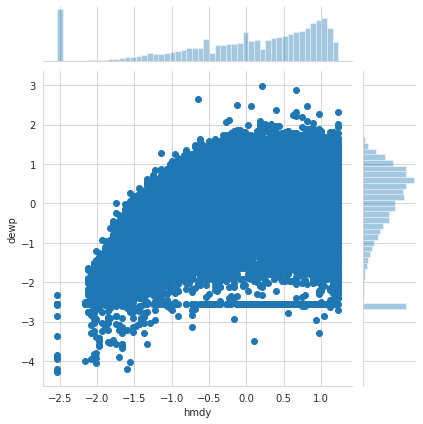

In [283]:
sns.jointplot(sample_df_norm['hmdy'],sample_df_norm['dewp']);

### Humidity and WindSpeed

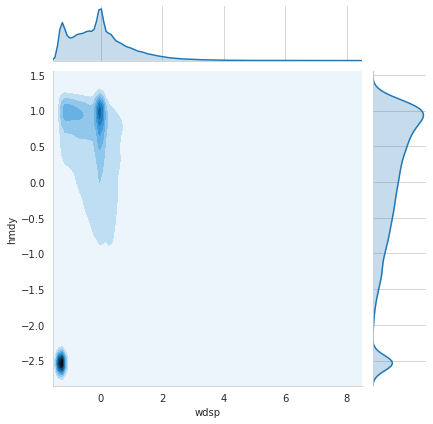

In [286]:
sns.jointplot(sample_df_norm['wdsp'],sample_df_norm['hmdy'], kind='kde');

The plot is denser on the left and botteom. So, it seems wind-speed and humidity are reversely proportional to each other. Increase in wind-speed causes decrease in humidity. Also the humidity is right skewed data.